In [128]:
# ======================================================================
# There are 5 questions in this exam with increasing difficulty from 1-5.
# Please note that the weight of the grade for the question is relative
# to its difficulty. So your Category 1 question will score significantly
# less than your Category 5 question.
#
# Don't use lambda layers in your model.
# You do not need them to solve the question.
# Lambda layers are not supported by the grading infrastructure.
#
# You must use the Submit and Test button to submit your model
# at least once in this category before you finally submit your exam,
# otherwise you will score zero for this category.
# ======================================================================
#
# NLP QUESTION
#
# Build and train a classifier for the sarcasm dataset.
# The classifier should have a final layer with 1 neuron activated by sigmoid as shown.
# It will be tested against a number of sentences that the network hasn't previously seen
# and you will be scored on whether sarcasm was correctly detected in those sentences.


# @author: Stefan Lippl

In [5]:
import json
import tensorflow as tf
import numpy as np
import pandas as pd
import urllib
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
# Download dataset
"""
# url = 'https://storage.googleapis.com/download.tensorflow.org/data/sarcasm.json'
# urllib.request.urlretrieve(url, 'sarcasm.json')
"""

"\n# url = 'https://storage.googleapis.com/download.tensorflow.org/data/sarcasm.json'\n# urllib.request.urlretrieve(url, 'sarcasm.json')\n"

In [8]:
df = pd.read_json('./archive/Sarcasm_Headlines_Dataset.json', lines=True)

In [9]:
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [10]:
print(df.info())
print("\n--------------------------------\n")
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB
None

--------------------------------

       is_sarcastic
count  26709.000000
mean       0.438953
std        0.496269
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000


In [11]:
# How many examples of each class?
df.is_sarcastic.value_counts()

0    14985
1    11724
Name: is_sarcastic, dtype: int64

In [12]:
df_sentence = df["headline"]
df_label = df["is_sarcastic"]

In [13]:
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(df_sentence.to_numpy(),
                                                                            df_label.to_numpy(),
                                                                            test_size=0.1, 
                                                                            random_state=42)

len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(24038, 2671, 24038, 2671)

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

In [2]:
# Download and quick test the USE 
# for more acc but longer train use USE_large v.5 at: https://tfhub.dev/google/universal-sentence-encoder-large/5  
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embeddings = embed([
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"])

print()
print(embeddings)

OSError: SavedModel file does not exist at: /var/folders/2t/787ddcxd1tz19w0vwyb3tz4c0000gn/T/tfhub_modules/063d866c06683311b44b4992fd46003be952409c/{saved_model.pbtxt|saved_model.pb}

In [3]:
# Place the USE into an encoder_layer for later use in model
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-large/5",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")


OSError: SavedModel file does not exist at: /var/folders/2t/787ddcxd1tz19w0vwyb3tz4c0000gn/T/tfhub_modules/c9fe785512ca4a1b179831acb18a0c6bfba603dd/{saved_model.pbtxt|saved_model.pb}

In [156]:
import tensorflow as tf

model = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")
], name="model_USE_large_v5")

# Compile model
model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [157]:
model.summary()

Model: "model_USE_large_v5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               147354880 
_________________________________________________________________
dense_14 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 147,387,777
Trainable params: 32,897
Non-trainable params: 147,354,880
_________________________________________________________________


In [158]:
# Setup callbacks
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="./model_checkpoint/checkpoint.ckpt",
                                                      save_weights_only=True, # set to False to save the entire model
                                                      save_best_only=True, # set to True to save only the best model instead of a model every epoch 
                                                      save_freq="epoch",
                                                      verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, 
                                                  monitor="val_loss",
                                                  verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor=0.2, 
                                                 patience=2, 
                                                 min_lr=0.001,
                                                 verbose=1)

callbacks=[model_checkpoint, 
           early_stopping, 
           reduce_lr]

In [159]:
# Train a classifier on top of pretrained embeddings

history_model = model.fit(train_sentences,
                              train_labels,
                              epochs=50,
                              validation_data=(val_sentences, val_labels),
                              callbacks=callbacks)

Epoch 1/50
752/752 [==============================] - 113s 125ms/step - loss: 0.4958 - accuracy: 0.7730 - val_loss: 0.3505 - val_accuracy: 0.8416

Epoch 00001: val_loss improved from inf to 0.35045, saving model to ./model_checkpoint/checkpoint.ckpt
Epoch 2/50
752/752 [==============================] - 87s 115ms/step - loss: 0.3400 - accuracy: 0.8539 - val_loss: 0.3375 - val_accuracy: 0.8517

Epoch 00002: val_loss improved from 0.35045 to 0.33746, saving model to ./model_checkpoint/checkpoint.ckpt
Epoch 3/50
752/752 [==============================] - 87s 116ms/step - loss: 0.3359 - accuracy: 0.8501 - val_loss: 0.3308 - val_accuracy: 0.8532

Epoch 00003: val_loss improved from 0.33746 to 0.33083, saving model to ./model_checkpoint/checkpoint.ckpt
Epoch 4/50
752/752 [==============================] - 92s 122ms/step - loss: 0.3241 - accuracy: 0.8575 - val_loss: 0.3239 - val_accuracy: 0.8562

Epoch 00004: val_loss improved from 0.33083 to 0.32389, saving model to ./model_checkpoint/checkpo

In [161]:
model.load_weights('./model_checkpoint/checkpoint.ckpt')
eval_model = model.evaluate(val_sentences, val_labels)

84/84 [==============================] - 9s 106ms/step - loss: 0.2800 - accuracy: 0.8794


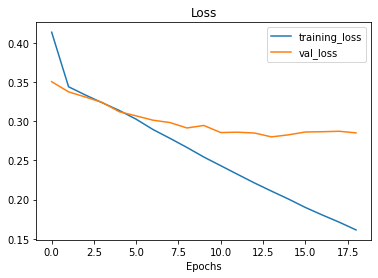

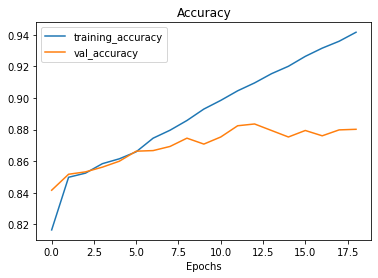

In [163]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();
    
plot_loss_curves(history_model)

In [164]:
# Make predictions with USE TF Hub model
model_pred_probs = model.predict(val_sentences)
model_pred_probs[:10]

array([[0.9979791 ],
       [0.05383137],
       [0.03954953],
       [0.791773  ],
       [0.14277613],
       [0.998124  ],
       [0.0709168 ],
       [0.20855528],
       [0.01051721],
       [0.01500136]], dtype=float32)

In [165]:
# Convert prediction probabilities to labels
model_preds = tf.squeeze(tf.round(model_pred_probs))
model_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 0., 0., 1., 0., 1., 0., 0., 0., 0.], dtype=float32)>

In [166]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_results(y_true, y_pred):
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall and f1 score using "weighted" average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": round(model_accuracy, 4),
                  "precision": round(model_precision, 4),
                  "recall": round(model_recall, 4),
                  "f1": model_f1}
    return model_results

calculate_results(val_labels,
                  model_preds)

{'accuracy': 87.9446,
 'precision': 0.8794,
 'recall': 0.8794,
 'f1': 0.8794459004118308}

In [4]:
"""
*USE v4
'accuracy': 84.2381,
'precision': 0.8422,
'recall': 0.8424,
'f1': 0.8422394450297833

*USE large v5
'accuracy': 87.9446,
'precision': 0.8794,
'recall': 0.8794,
'f1': 0.8794459004118308
"""

"\n*USE v4\n'accuracy': 84.2381,\n'precision': 0.8422,\n'recall': 0.8424,\n'f1': 0.8422394450297833\n\n*USE large v5\n'accuracy': 87.9446,\n'precision': 0.8794,\n'recall': 0.8794,\n'f1': 0.8794459004118308\n"

In [5]:
12015 / 650

18.484615384615385